# 사진->그림 파인튜닝 후 그림 예측  
추가해야할 코드  
- 그림데이터 증강
- Grad-CAM 시각화
- 추론 코드 (학습된 모델을 이용해서 새로운 이미지나 데이터에 대해 감정을 예측하는 과정을 자동화한 코드)
- 어플제작?

In [1]:
# 라이브러리 불러오기
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report

# GPU 사용 여부
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 디바이스: {device}")

사용 중인 디바이스: cuda


In [2]:
# 하이퍼파라미터 설정
BATCH_SIZE = 32
LR = 1e-4
EPOCHS_PHOTO = 10
EPOCHS_DRAWING = 200
EARLY_STOPPING_PATIENCE = 7
EARLY_STOPPING_DELTA = 0.001

In [3]:
# 데이터 전처리 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [4]:
# 사진 데이터셋 로드 (train/val 나눔)
photo_dataset = datasets.ImageFolder('dataset/photo', transform=transform)

train_size = int(0.8 * len(photo_dataset))
val_size = len(photo_dataset) - train_size
photo_train, photo_val = random_split(photo_dataset, [train_size, val_size])

photo_train_loader = DataLoader(photo_train, batch_size=BATCH_SIZE, shuffle=True)
photo_val_loader = DataLoader(photo_val, batch_size=BATCH_SIZE)

In [5]:
# 그림 데이터셋 로드 (train/val 나눔)
drawing_dataset = datasets.ImageFolder('dataset/drawing', transform=transform)

train_size = int(0.8 * len(drawing_dataset))
val_size = len(drawing_dataset) - train_size
drawing_train, drawing_val = random_split(drawing_dataset, [train_size, val_size])

drawing_train_loader = DataLoader(drawing_train, batch_size=BATCH_SIZE, shuffle=True)
drawing_val_loader = DataLoader(drawing_val, batch_size=BATCH_SIZE)

# 그림용 transform (augmentation 포함)
drawing_train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [6]:
# 모델 준비 (ResNet18 사용)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)  # 감정 4개
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

## YOLOv8-cls 다음 시도할것.

/workspace/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# 학습 함수 정의
def train(model, loader):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

In [8]:
# 검증 함수 정의
def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    print(classification_report(all_labels, all_preds, target_names=photo_dataset.classes))

In [9]:
# Step 1 - 사진 데이터로 사전학습
print("🔵 Step 1: 사진 데이터로 학습")
for epoch in range(EPOCHS_PHOTO):
    loss = train(model, photo_train_loader)
    print(f"[{epoch+1}/{EPOCHS_PHOTO}] loss: {loss:.4f}")
print("✅ 사진 기반 성능 확인")
evaluate(model, photo_val_loader)

🔵 Step 1: 사진 데이터로 학습


[1/10] loss: 0.9280
[2/10] loss: 0.3650
[3/10] loss: 0.1068
[4/10] loss: 0.0359
[5/10] loss: 0.0309
[6/10] loss: 0.0437
[7/10] loss: 0.0595
[8/10] loss: 0.0430
[9/10] loss: 0.0283
[10/10] loss: 0.0293
✅ 사진 기반 성능 확인
              precision    recall  f1-score   support

       angry       0.72      0.67      0.70       373
        fear       0.88      0.61      0.72       344
       happy       0.72      0.96      0.82       358
     sadness       0.76      0.78      0.77       365

    accuracy                           0.76      1440
   macro avg       0.77      0.76      0.75      1440
weighted avg       0.77      0.76      0.75      1440



In [10]:
# 모델 저장

MODEL_PATH = "photo_pretrained.pth"
torch.save(model.state_dict(), MODEL_PATH)

In [33]:
# Step 2 - 그림 데이터로 파인튜닝 (fc 레이어만)
for name, param in model.named_parameters():
    param.requires_grad = False
for name, param in model.fc.named_parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

# EarlyStopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# evaluate 함수에서 val_loss 리턴하게 수정 필요
def evaluate(model, val_loader, return_loss=False):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    acc = 100 * correct / total

    if return_loss:
        return avg_loss
    else:
        print(f"🔍 Val Accuracy: {acc:.2f}%")

In [34]:
# 그림 데이터 학습 시작
early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, delta=EARLY_STOPPING_DELTA)

print("🟣 Step 2: 그림 데이터로 파인튜닝")
for epoch in range(EPOCHS_DRAWING):
    loss = train(model, drawing_train_loader)
    val_loss = evaluate(model, drawing_val_loader, return_loss=True)

    print(f"[{epoch+1}/{EPOCHS_DRAWING}] train_loss: {loss:.4f} | val_loss: {val_loss:.4f}")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("⛔ Early stopping triggered.")
        break

# 최종 성능 확인
print("✅ 그림 기반 성능 확인")
evaluate(model, drawing_val_loader)

🟣 Step 2: 그림 데이터로 파인튜닝


[1/200] train_loss: 1.2553 | val_loss: 1.2717
[2/200] train_loss: 1.2602 | val_loss: 1.2735
[3/200] train_loss: 1.2592 | val_loss: 1.2724
[4/200] train_loss: 1.2592 | val_loss: 1.2700
[5/200] train_loss: 1.2404 | val_loss: 1.2653
[6/200] train_loss: 1.2511 | val_loss: 1.2645
[7/200] train_loss: 1.2624 | val_loss: 1.2638
[8/200] train_loss: 1.2399 | val_loss: 1.2638
[9/200] train_loss: 1.2299 | val_loss: 1.2620
[10/200] train_loss: 1.2345 | val_loss: 1.2609
[11/200] train_loss: 1.2389 | val_loss: 1.2590
[12/200] train_loss: 1.2286 | val_loss: 1.2540
[13/200] train_loss: 1.2383 | val_loss: 1.2528
[14/200] train_loss: 1.2302 | val_loss: 1.2508
[15/200] train_loss: 1.2337 | val_loss: 1.2523
[16/200] train_loss: 1.2223 | val_loss: 1.2487
[17/200] train_loss: 1.2278 | val_loss: 1.2491
[18/200] train_loss: 1.2193 | val_loss: 1.2478
[19/200] train_loss: 1.2125 | val_loss: 1.2403
[20/200] train_loss: 1.2195 | val_loss: 1.2439
[21/200] train_loss: 1.2122 | val_loss: 1.2383
[22/200] train_loss: 1

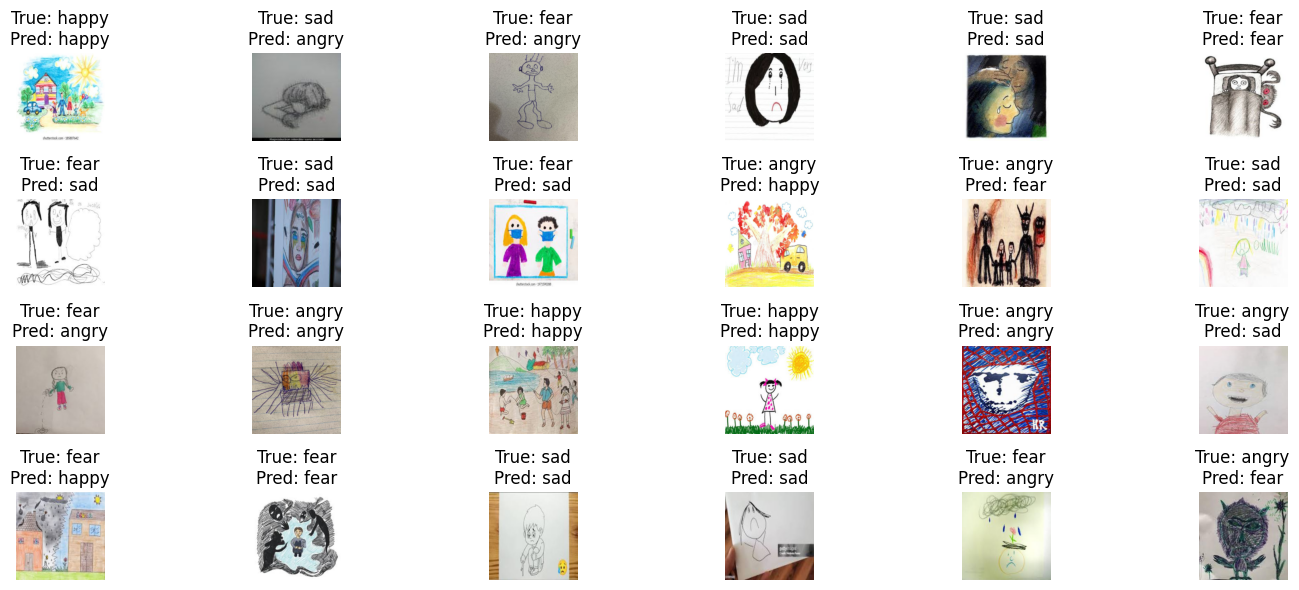

In [36]:
# 그림 데이터로 예측 및 시각화
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# 클래스 이름
class_names = drawing_dataset.classes

# 모델 평가 모드로 변경
model.eval()

# 한 번에 보여줄 이미지 수
num_images = 24

images_shown = 0
fig = plt.figure(figsize=(15, 6))

with torch.no_grad():
    for images, labels in drawing_val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()

        images = images.cpu()

        for i in range(len(images)):
            ax = fig.add_subplot(4, 6, images_shown + 1)
            img = images[i]
            img = torchvision.transforms.functional.to_pil_image(img)
            ax.imshow(img)
            true_label = class_names[labels[i]]
            pred_label = class_names[preds[i]]
            ax.set_title(f"True: {true_label}\nPred: {pred_label}")
            ax.axis('off')

            images_shown += 1
            if images_shown == num_images:
                plt.tight_layout()
                plt.show()
                break
        if images_shown == num_images:
            break


In [ ]:
# 모델 저장 (선택)
torch.save(model.state_dict(), "emotion_model_finetuned.pt")
print("📁 모델 저장 완료")